### Importing necessary libraries and loading the data

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix

### Data loading and initial exploration

In [140]:
data = pd.read_csv("skab_valve_1.csv", sep=';', parse_dates=['datetime'])
data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')

In [141]:
# Отображение первых строк данных
data.head()

,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
0,2020-03-09 12:34:37,0.028030,0.040400,1.18285,0.054711,69.9219,24.9122,229.918,32.9875,0.0,0.0
1,2020-03-09 12:34:38,0.026952,0.038880,1.45268,-0.273216,69.9147,24.9038,219.566,32.0129,0.0,0.0
2,2020-03-09 12:34:39,0.027958,0.040660,1.02300,0.054711,69.8861,24.9055,237.717,32.9875,0.0,0.0
3,2020-03-09 12:34:40,0.027277,0.040736,1.22751,-0.273216,69.8397,24.9110,227.621,32.0000,0.0,0.0
4,2020-03-09 12:34:41,0.027210,0.039489,1.21526,-0.273216,69.9136,24.9110,221.634,32.0129,0.0,0.0


### Detecting anomalies using IQR

In [142]:
def detect_anomalies_iqr(data, column):
    # Вычисление первого (Q1) и третьего (Q3) квартилей
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    # Вычисление интерквартильного размаха (IQR)
    IQR = Q3 - Q1
    # Определение границ для аномалий
    lower_bound_1_5 = Q1 - (1.5 * IQR)
    upper_bound_1_5 = Q3 + (1.5 * IQR)
    lower_bound_3 = Q1 - (3 * IQR)
    upper_bound_3 = Q3 + (3 * IQR)

    return lower_bound_1_5, upper_bound_1_5, lower_bound_3, upper_bound_3

### Marking and visualizing anomalies for thermocouple data

In [143]:
column = 'Thermocouple'
lower_bound_1_5, upper_bound_1_5, lower_bound_3, upper_bound_3 = detect_anomalies_iqr(data, column)

In [144]:
# Обозначение аномалий в данных
data['anomaly_iqr_1_5'] = ((data[column] < lower_bound_1_5) | (data[column] > upper_bound_1_5)).astype(int)
data['anomaly_iqr_3'] = ((data[column] < lower_bound_3) | (data[column] > upper_bound_3)).astype(int)

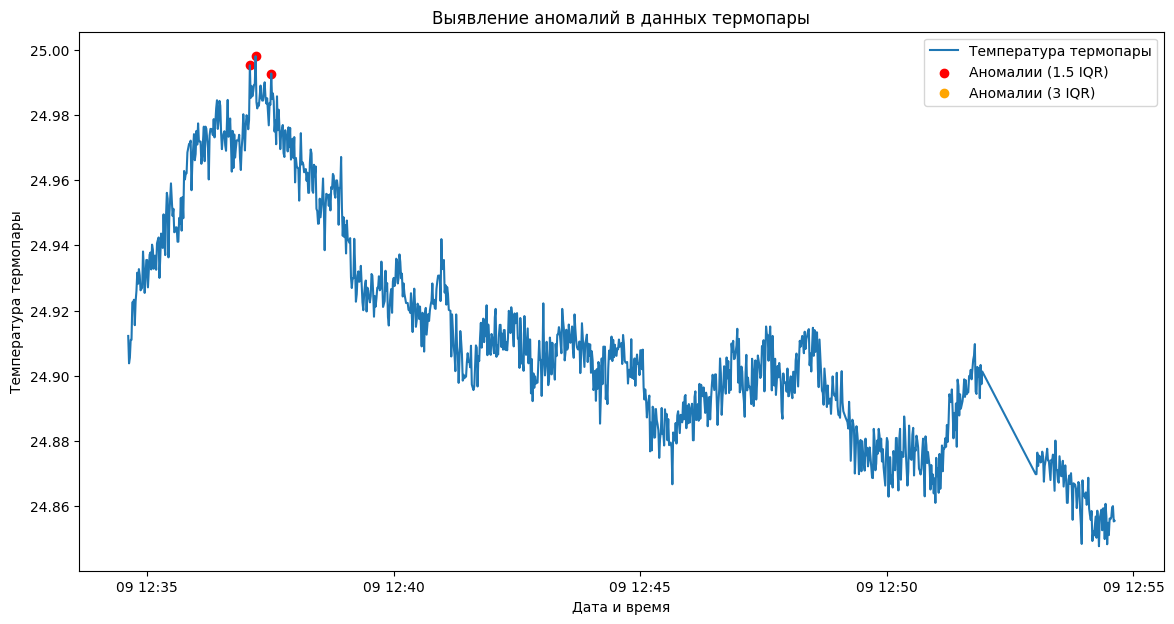

In [145]:
# Визуализация данных с аномалиями
plt.figure(figsize=(14, 7))
plt.plot(data['datetime'], data['Thermocouple'], label='Температура термопары')
plt.scatter(data['datetime'][data['anomaly_iqr_1_5'] == 1],
            data['Thermocouple'][data['anomaly_iqr_1_5'] == 1],
            color='red', label='Аномалии (1.5 IQR)')
plt.scatter(data['datetime'][data['anomaly_iqr_3'] == 1],
            data['Thermocouple'][data['anomaly_iqr_3'] == 1],
            color='orange', label='Аномалии (3 IQR)')
plt.title("Выявление аномалий в данных термопары")
plt.xlabel("Дата и время")
plt.ylabel("Температура термопары")
plt.legend()
plt.show()

### Confusion matrix for IQR method

In [146]:
conf_matrix_iqr_1_5 = confusion_matrix(data['anomaly'], data['anomaly_iqr_1_5'])
conf_matrix_iqr_3 = confusion_matrix(data['anomaly'], data['anomaly_iqr_3'])
print("Матрица ошибок (1.5 IQR):\n", conf_matrix_iqr_1_5)
print("Матрица ошибок (3 IQR):\n", conf_matrix_iqr_3)

Матрица ошибок (1.5 IQR):
 [[686   3]
 [405   0]]
Матрица ошибок (3 IQR):
 [[689   0]
 [405   0]]


### Feature Engineering

In [147]:
data['hour'] = data['datetime'].dt.hour  # Час
data['day_of_week'] = data['datetime'].dt.dayofweek  # День недели
data['month'] = data['datetime'].dt.month  # Месяц
data['Lag'] = data['Thermocouple'].shift(1)
data['rolling_mean'] = data['Thermocouple'].rolling(window=5).mean()  # Скользящее среднее
data['rolling_std'] = data['Thermocouple'].rolling(window=5).std()  # Скользящее стандартное отклонение

### Clustering anomalies using DBSCAN

In [148]:
features = data[['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
                 'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS',
                 'hour', 'day_of_week', 'month', 'rolling_mean', 'rolling_std']].fillna(0)

In [149]:
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(features)
data['dbscan_labels'] = dbscan.labels_

### Visualizing DBSCAN clusters

In [150]:
data['anomaly_dbscan'] = (data['dbscan_labels'] == -1).astype(int)

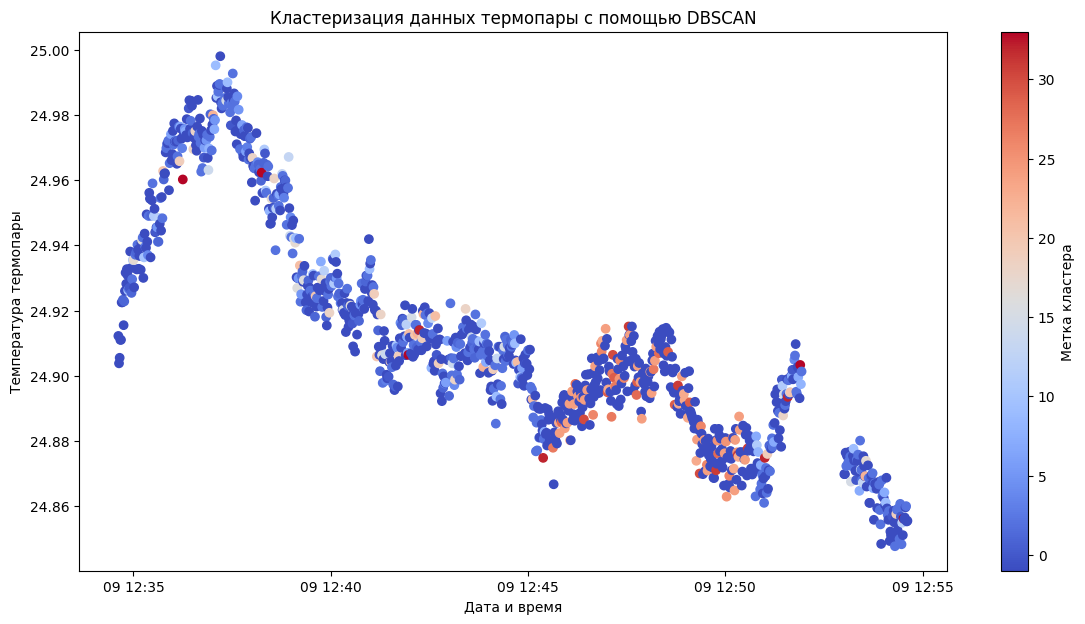

Матрица ошибок (DBSCAN):
 [[365 324]
 [136 269]]


In [151]:
# Визуализация результатов DBSCAN
plt.figure(figsize=(14, 7))
plt.scatter(data['datetime'], data['Thermocouple'], c=data['dbscan_labels'], cmap='coolwarm', label='Кластеры DBSCAN')
plt.title("Кластеризация данных термопары с помощью DBSCAN")
plt.xlabel("Дата и время")
plt.ylabel("Температура термопары")
plt.colorbar(label='Метка кластера')
plt.show()

conf_matrix_dbscan = confusion_matrix(data['anomaly'], data['anomaly_dbscan'])
print("Матрица ошибок (DBSCAN):\n", conf_matrix_dbscan)

### Using Isolation Forest for anomaly detection

---



In [152]:
data = data.dropna()

In [153]:
x = data[['Thermocouple', 'Lag', 'rolling_mean']]
y = data['anomaly']
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

In [154]:
clf = IsolationForest(max_samples=100, random_state=42)
clf.fit(x_train)

IsolationForest(max_samples=100, random_state=42)

In [155]:
y_pred = clf.fit_predict(x_test)

y_pred = np.where(y_pred == 1, 0, 1)

# Visualization Isolation Forest

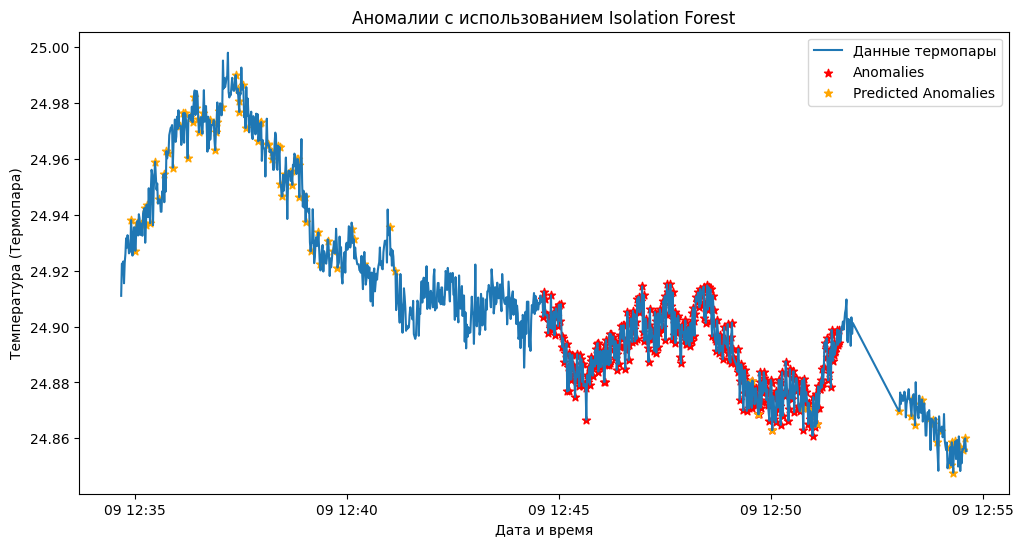

Матрица ошибок (Isolation Forest):
 [[84 88]
 [92  9]]


In [156]:
plt.figure(figsize=(12, 6))
plt.plot(data['datetime'], data['Thermocouple'], label='Данные термопары')
anomalies_if = data[data['anomaly'] == 1]
plt.scatter(anomalies_if['datetime'], anomalies_if['Thermocouple'], color='red', label='Anomalies', marker='*')
predicted_anomalies = data.loc[X_test.index]
predicted_anomalies['predicted_anomaly'] = y_pred
anomalies_predicted = predicted_anomalies[predicted_anomalies['predicted_anomaly'] == 1]
plt.scatter(anomalies_predicted['datetime'], anomalies_predicted['Thermocouple'],
            color='orange', label='Predicted Anomalies', marker='*')
plt.title('Аномалии с использованием Isolation Forest')
plt.xlabel('Дата и время')
plt.ylabel('Температура (Термопара)')
plt.legend()
plt.show()

# Confusion matrix для Isolation Forest
conf_matrix_iso = confusion_matrix(y_test, y_pred)
print("Матрица ошибок (Isolation Forest):\n", conf_matrix_iso)

# Results

In [157]:
# Преобразуем матрицы ошибок в DataFrame с колонками TN, FP, FN, TP
def conf_to_df(cm, model_name):
    TN, FP, FN, TP = cm.ravel()
    return pd.DataFrame({
        'Model': [model_name],
        'TN': [TN],
        'FP': [FP],
        'FN': [FN],
        'TP': [TP]
    })

conf_matrix_iso_df = conf_to_df(conf_matrix_iso, 'Isolation Forest')
conf_matrix_df = conf_to_df(conf_matrix_dbscan, 'Clustering')
conf_matrix_iqr_1_5_df = conf_to_df(conf_matrix_iqr_1_5, 'Statistical')

# Объединяем все данные в один DataFrame
results = pd.concat([conf_matrix_iso_df, conf_matrix_df, conf_matrix_iqr_1_5_df], ignore_index=True)

In [158]:
results

,Model,TN,FP,FN,TP
0,Isolation Forest,84,88,92,9
1,Clustering,365,324,136,269
2,Statistical,686,3,405,0
